## Problem Set 4, Solution
**Stats 507, Fall 2021**  
*James Henderson, PhD*  
*October 22, 2021*


## Contents
+ [Question 1](#Question-1)
+ [Question 2](#Question-2)

Note that I am not providing an example solution for question 0. 

## Imports
We will use the following imports in this assignment.

In [1]:
# modules: --------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from collections import defaultdict
from scipy.stats import chi2_contingency, ttest_ind
from scipy.stats import norm, beta
from ci_funcs import ci_mean, ci_prop
# 79: -------------------------------------------------------------------------

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'axes.titlesize': 'x-large'}
pylab.rcParams.update(params)

## Question 1 - Balance Table for Missing Outcomes

In this question we construct a balance table comparing the demographics of
those with and without a missing dentition exam in our aggregate of four
NHANES cohorts. 

### part a) Load data
In this part, you modified your previous code to add gender to the
demographic data. Here, we load the revised demographics dataset and the 
original dentition data. 

In [3]:
# NHANES demographics 
demo_file = 'demo.feather'
demo = pd.read_feather(demo_file)

# NHANES dentition
ohx_file = 'ohx.feather'
ohx = pd.read_feather(ohx_file)

### part b) Oral Health Exam Status and Derived Variables
In this part we identify those with a missing oral health exam and 
construct derived variables by collapsing levels of education and 
distinguishing those under and over 20 years of age. 

In [4]:
# merge dentition exam status into demo
n0 = demo.shape[0]
df = pd.merge(demo, ohx[['id', 'dentition_status']], on='id', how='left')
df.rename(columns={'dentition_status': 'ohx_status'}, inplace=True)
assert n0 == df.shape[0]

# missingness
df['ohx'] = np.logical_and(
    df['ohx_status'] == 'Complete', 
    df['exam_status'] == 'Both interviewed and MEC examined'
)
df['ohx'] = df['ohx'].replace({True: 'Complete', False: 'Missing'})
df['ohx'] = pd.Categorical(df['ohx'])

# derived variables
df['under_20'] = df['age'] < 20

college = ('College graduate or above', 'Some college or AA degree')
df['college'] = np.logical_and(
    df['education'].apply(lambda x: x in college).replace({np.nan: False}),
    ~df['under_20']
)
df['college'] = df['college'].replace(
    {True: 'Some College/College Graduate',
     False: 'No College/<20'
    })
df['college'] = pd.Categorical(df['college'])

df['under_20'] = (
    df['under_20']
    .replace({True: '<20 years old', False: '20+ years old'})
)

# minimal and derived variables to examine associations
cols = ['id', 'gender', 'age', 'under_20', 'college', 'exam_status', 'ohx']
df = df[cols]

In [5]:
df.groupby(['under_20', 'college'], as_index=False).size()

,under_20,college,size
0,20+ years old,No College/<20,10122
1,20+ years old,Some College/College Graduate,12495
2,<20 years old,No College/<20,16539
3,<20 years old,Some College/College Graduate,0


## part c) Drop missing already accounted for
In this part we drop those whom were interviewed only, as these
missing values are already accounted for in the MEC weights.

In [6]:
# drop those not given any medical exams
df = df.query('exam_status == "Both interviewed and MEC examined"')

## part d) Balance Table
Finally, in this part we construct a table to examine associations
between select demographics and a missing oral health (dentition) exam.


In [7]:
# 79: -------------------------------------------------------------------------
def assess_balance(rows, cols, df):
    """
    Construct categorical rows for a balance table from in a DataFrame. 
    
    Parameters
    ----------
    rows: str
    Categorical column in df whose levels will form rows in the balance table.
    
    cols: str
    Categorical column in df whose levels will from columns in the
    balance table.
    
    df: DataFrame
    DataFrame where variables specified in rows and cols are found. 

    Returns
    -------
    Returns a pandas DataFrame giving counts and (row) percents for each
    unique combination of the levels for the variables specified using 
    rows and cols and a p-value from Chi-squared test of independence.
    """
    # count
    row = df.groupby([rows, cols], as_index=False).size()
    # contingency table
    tab = row.pivot(index=rows, columns=cols, values='size').to_numpy()
    # p-value
    p = chi2_contingency(tab)[1]
    p_str = 'p < 0.001' if p < 0.001 else 'p = {0:5.3f}'.format(p)
    # format output
    row['pct'] = (
        row
        .groupby(rows, as_index=False)['size']
        .transform(lambda x: x / np.sum(x) * 100)
    )
    row = (
        row
        .groupby([rows, cols], as_index=False)
        .apply(lambda gdf: '{0:d} ({1:.1f}%)'.format(
            gdf['size'].values[0],
            gdf['pct'].values[0]
            )
        )
    ).pivot(index=rows, columns=cols)
    row.columns = [i[1] for i in row.columns]
    row['p-value'] = ['-' if i > 0 else p_str for i in range(row.shape[0])]
    row.index.name = 'variable'
    return(row)

In [8]:
# 79: -------------------------------------------------------------------------
def compare_means(row, cols, df):
    """
    Compare means in a balance table. 
    
    Parameters
    ----------
    row: str
    Numeric column in df whose means will be compared across levels of cols.
    
    cols: str
    Categorical column in df whose levels will from columns in the
    balance table.
    
    df: DataFrame
    DataFrame where variables specified in rows and cols are found. 

    Returns
    -------
    Returns a pandas DataFrame giving mean and std of df[row] for each
    level of cols and a p-value from a two-sample t-test. 
    """
    # means and sd
    tab = (
        df
        .groupby(cols, as_index=False)[row]
        .apply(lambda x: '{0:.1f} ({1:.1f})'.format(
                np.mean(x), np.std(x, ddof=1)
            )
        )
    )
    tab = tab.set_index(cols).transpose()
    tab.columns.name = None
    
    # p-value
    vals = []
    for v in tab.columns.categories:
        vals.append(df[row].values[np.where(df[cols] == v)])
    
    p = ttest_ind(vals[0], vals[1])[1]
    p_str = 'p < 0.001' if p < 0.001 else 'p = {0:5.3f}'.format(p)
    
    # format output
    tab['p-value'] = ['-' if i > 0 else p_str for i in range(tab.shape[0])]
    return(tab)

In [9]:
# 79: -------------------------------------------------------------------------
row, cols = 'age', 'ohx'
tab = (
    df
    .groupby(cols, as_index=False)[row]
    .apply(lambda x: '{0:.1f} ({1:.1f})'.format(
            np.mean(x), np.std(x, ddof=1)
        )
    )
)
tab = tab.set_index(cols).transpose()
tab.columns.name = None

vals = []
for v in tab.columns.categories:
    vals.append(df[row].values[np.where(df[cols] == v)])
p = ttest_ind(vals[0], vals[1])[1]
compare_means('age', 'ohx', df)

,Complete,Missing,p-value
age,33.2 (24.4),22.0 (26.6),p < 0.001


In [10]:
cat_vars = ('gender', 'under_20', 'college')
table_rows = [compare_means('age', 'ohx', df)]
for v in cat_vars:
    table_rows.append(assess_balance(v, 'ohx', df))
table_rows = [table_rows[1]] + [table_rows[0]] + table_rows[2:len(table_rows)]
pd.concat(table_rows)

,Complete,Missing,p-value
Female,17342 (91.4%),1626 (8.6%),p = 0.001
Male,17018 (92.3%),1413 (7.7%),-
age,33.2 (24.4),22.0 (26.6),p < 0.001
20+ years old,20369 (94.1%),1277 (5.9%),p < 0.001
<20 years old,13991 (88.8%),1762 (11.2%),-
No College/<20,22974 (90.4%),2427 (9.6%),p < 0.001
Some College/College Graduate,11386 (94.9%),612 (5.1%),-


## Question 2  
In this question we carry out a small simulation study
examining the achieved confidence level of five methods for
constructing a confidence interval for a proportion. In addition,
we compare the widths of these confidence intervals. 

I will use confidence level of 0.95 for the comparisions. In order
to achieve an expected Monte Carlo margin of error (using 95% 
confidence again) I solve the inequality below:

$$
\Phi^{-1}(.975)\frac{\sqrt{.95 * (1 - .95)}}{\sqrt{m}} < 0.005.
$$

Solving for the number of Monte Carlo samples $m$,

$$
\left(\Phi^{-1}(.975)\frac{\sqrt{.95 * (1 - .95)}}{0.005}\right)^2 < m .
$$



In [11]:
np.ceil(((norm.ppf(.975) / 0.005) ** 2) * .95 * (1 - .95))

7299.0

I'll round this up to 10,000 Monte Carlo replications. Below,
I generate Monte Carlo samples for each combination of a sample size
$n$ and a population proportion $p$ over a grid of values. 

In [12]:
rng = np.random.default_rng(10 * 18 * 2021)

m = 10000
n_seq = [int(5 * (i + 2)) for i in range(19) ]
p_seq = [np.round(0.05 * (i + 1), 2) for i in range(10)]
level = 0.95

# loop over grid and compute results
cis = dict()
for n in n_seq:
    for p in p_seq:
        x = rng.binomial(1, p, size=(n, m))
        method = 'mean'
        cis[(n, p, method)] = ci_mean(x, axis=0, level=level, str_fmt=None)
        for method in ['Normal', 'AC', 'CP', 'Jeffrey']:
            cis[(n, p, method)] = ci_prop(
                x,
                axis=0,
                method=method,
                level=level,
                str_fmt=None,
                warn=False
            )

### a) achieved confidence level

In [13]:
results = defaultdict(list)
methods = ['mean', 'Normal', 'AC', 'CP', 'Jeffrey']
for n in n_seq:
    for p in p_seq:
        for method in methods:
            res = cis[(n, p, method)]
            results['n'].append(n)
            results['p'].append(p)
            results['method'].append(method)
            # Replace NaN with 0/1
            res['lwr'] = np.nan_to_num(res['lwr'], nan=0.0)
            res['upr'] = np.nan_to_num(res['upr'], nan=1.0)
            results['coverage'].append(
                np.mean(
                    np.logical_and(res['lwr'] < p, res['upr'] > p)
                )
            )
            results['width'].append(
                np.mean(res['upr'] - res['lwr'])
            )
results = pd.DataFrame(results)
methods = ['mean', 'Normal', 'AC', 'CP', 'Jeffrey']

Now we're ready to create plots visualizing the results. 

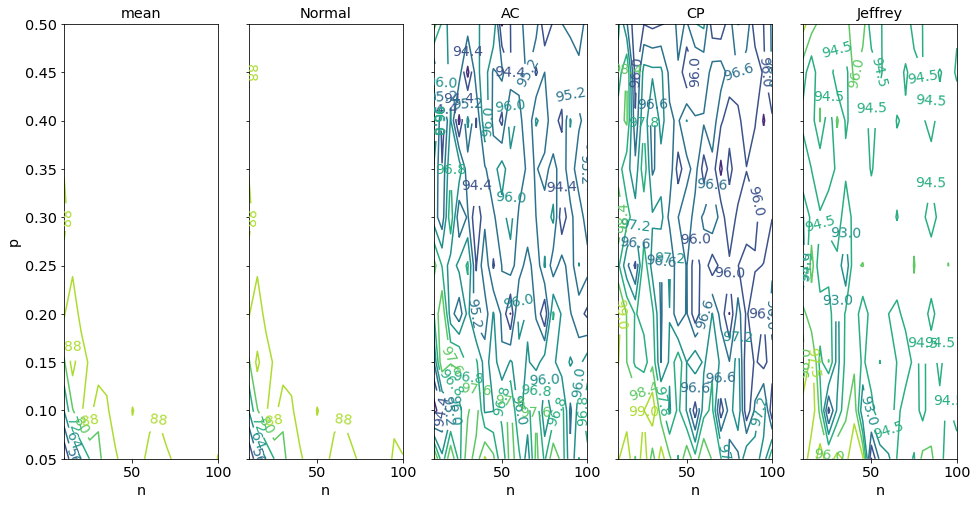

In [14]:
fig, ax = plt.subplots(ncols=5, sharex=True, sharey=True)
fig.set_size_inches(16, 8)
for i, m in enumerate(methods):
    res = results.query('method == @m')
    z = res['coverage'].to_numpy() * 100
    z = z.reshape((len(n_seq), len(p_seq)))
    CS = ax[i].contour(n_seq, p_seq, z.T)
    ax[i].clabel(CS, inline=True, fontsize=14)
    #ax[i].set_ylim((0, 0.5))
    ax[i].set_title(m)
    ax[i].set_xlabel('n')
_ = ax[0].set_ylabel('p')

**Figure 1.** *Estimated Contours for Achieved Confidence Levels.*

A countour plot was probably not the best choice for me to ask
you to make here. A better visualization would be as a series
of lines showing how coverage changes with n for each method and
value of $p$.


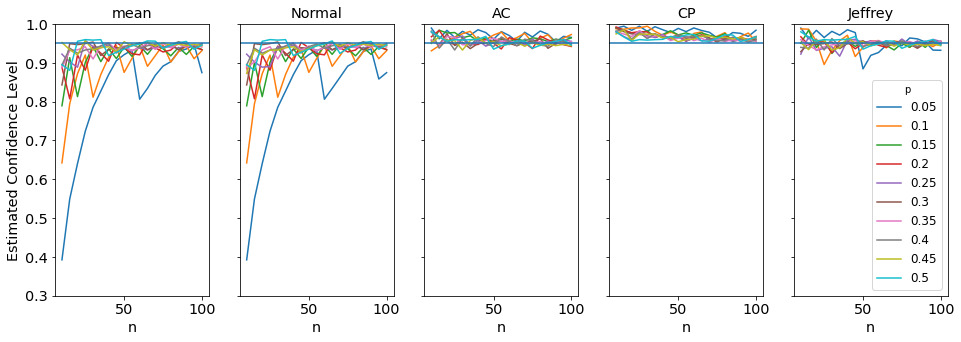

In [15]:
# plot as a series of lines
fig2, ax2 = plt.subplots(ncols=len(methods), sharex=True, sharey=True)
fig2.set_size_inches(16, 5)

for i, m in enumerate(methods):
    res = results.query('method == @m')
    res = pd.pivot(res, index='n', columns='p', values='coverage')
    res.plot.line(ax=ax2[i], legend=None)
    ax2[i].set_ylim((0.3, 1.0))
    ax2[i].set_title(m)
    ax2[i].set_xlabel('n')
    ax2[i].axhline(y=0.95)

_ = ax2[4].legend(loc='lower right', title='p')
_ = ax2[0].set_ylabel('Estimated Confidence Level')

**Figure 2.** *Comparisons of estimated achieved confidence levels for
5 Binomial Confidence Interval Methods.*

### b) Assess Efficiency by Visualizing the CI Widths
Now we're ready to visualize the efficiency as measured by
the average width of the confidence intervals each produced
by each method.

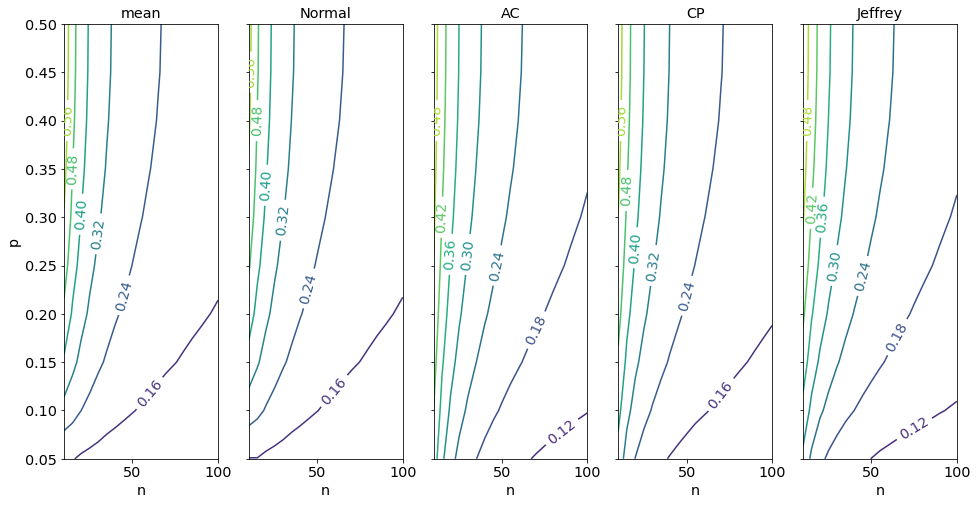

In [16]:
fig3, ax3 = plt.subplots(ncols=len(methods), sharex=True, sharey=True)
fig3.set_size_inches(16, 8)
for i, m in enumerate(methods):
    res = results.query('method == @m')
    z = res['width'].to_numpy()
    z = z.reshape((len(n_seq), len(p_seq)))
    CS = ax3[i].contour(n_seq, p_seq, z.T)
    ax3[i].clabel(CS, inline=True, fontsize=14)
    #ax[i].set_ylim((0, 0.5))
    ax3[i].set_title(m)
    ax3[i].set_xlabel('n')
    
_ = ax3[0].set_ylabel('p')

**Figure 3.** *Estimated countours for average width of
binomial confidence intervals.*

As we expect, larger $n$ give narrower confidence intervals and 
the role or $p$ is more prominent for smaller $n$.

Finally, we can compare the widths relative to the Clopper-Perason method.
First, we compute the relative widths below. 

In [17]:
# construct the widths relative to CP
results['rel_width'] = (   
    results
    .groupby(['p', 'n'])
    .apply(lambda gdf: (
        (gdf['width'] / gdf.query('method == "CP"')['width'].values)
        )
    )
    .values
)

Now we can visualize the relative widths. 

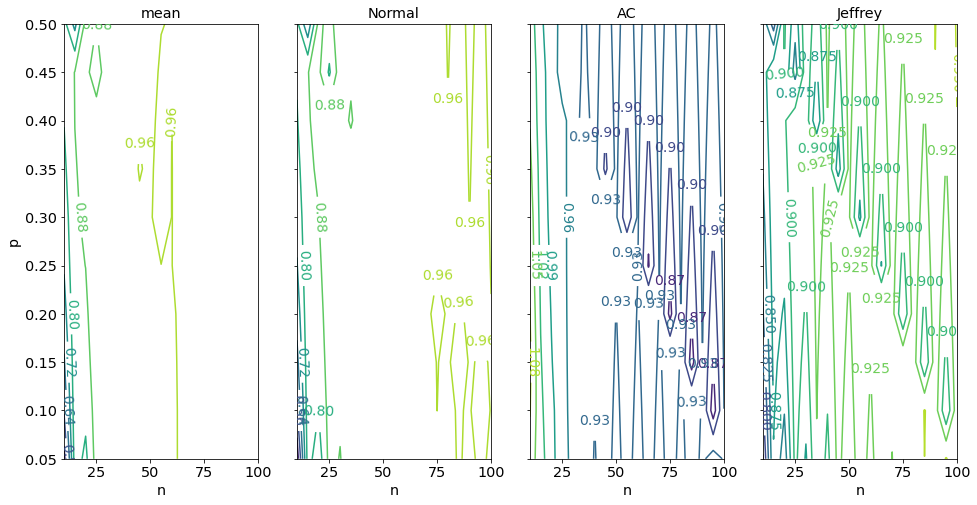

In [18]:
fig4, ax4 = plt.subplots(ncols=len(methods) - 1, sharex=True, sharey=True)
fig4.set_size_inches(16, 8)
methods_rel = ['mean', 'Normal', 'AC', 'Jeffrey']
for i, m in enumerate(methods_rel):
    res = results.query('method == @m')
    z = res['rel_width'].to_numpy()
    z = z.reshape((len(n_seq), len(p_seq)))
    CS = ax4[i].contour(n_seq, p_seq, z.T)
    ax4[i].clabel(CS, inline=True, fontsize=14)
    ax4[i].set_title(m)
    ax4[i].set_xlabel('n')
    
_ = ax4[0].set_ylabel('p')

**Figure 4.** *Average Width of Binomial Confidence Intervals,
relative to Clopper-Pearson.*

These too are probably better visualized using a series of lines. 

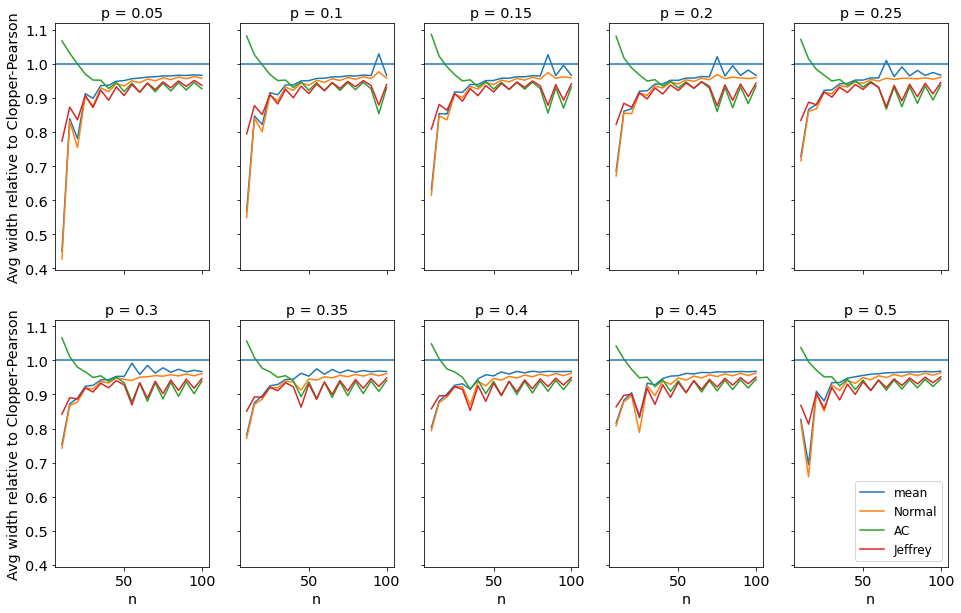

In [19]:
# plot as a series of lines
fig5, ax5 = plt.subplots(
    nrows=2,
    ncols=int(len(p_seq) // 2),
    sharex=True,
    sharey=True
)
fig5.set_size_inches(16, 10)

for i, p in enumerate(p_seq):
    r, c = i // 5, i % 5
    res = results.query('p == @p')
    res = pd.pivot(res, index='n', columns='method', values='rel_width')
    res = res[methods_rel]
    res.plot.line(ax=ax5[r, c], legend=None)
    ax5[r, c].set_title('p = ' + str(p))
    ax5[r, c].set_xlabel('n')
    ax5[r, c].axhline(y=1)

_ = ax5[1, 4].legend(loc='lower right')
_ = ax5[0, 0].set_ylabel('Avg width relative to Clopper-Pearson')
_ = ax5[1, 0].set_ylabel('Avg width relative to Clopper-Pearson')

**Figure 4.** *Average Width of Binomial Confidence Intervals,
relative to Clopper-Pearson.* Overall, it appears that the Jeffrey
and Agresti-Coull methods are most efficient for $n > 50$, while
the Jeffrey method also has good performance for small $n$.

---